In [1]:
import os
import pyspark

import pandas as pd
import re as re
import numpy as np
import sys, glob

from sparkdl import readImages
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit

#Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext


sys.path.extend(glob.glob(os.path.join(os.path.expanduser("~"), ".ivy2/jars/*.jar")))

Using TensorFlow backend.


In [4]:
!pip install sparkdl pillow keras tensorflow tensorframes kafka tensorflowonspark packaging jieba

In [ ]:
!pip list

In [2]:
os.environ['SPARK_OPTS'] = "--driver-java-options=-Xmx4096M --driver-java-options=-Dlog4j.logLevel=info --packages databricks:0.1.0-spark2.1-s_2.11"
print(os.environ['SPARK_OPTS'])

--driver-java-options=-Xmx4096M --driver-java-options=-Dlog4j.logLevel=info --packages databricks:0.1.0-spark2.1-s_2.11


In [3]:
conf=pyspark.SparkConf().setAppName("TEST").setMaster("spark://54.72.254.85:7077")
conf.set("spark.executor.memory", "3g")
conf.set("spark.driver.memory", "3g")

sc = pyspark.SparkContext(conf=conf)
sc

<SparkContext master=spark://54.72.254.85:7077 appName=TEST>

# Transfer Learning With PySpark

Here we'll be trying to develop a spark app that will leverage the power of deep learning for a multi class classification problem. We'll be using **Deep Learning Pipelines** which is an open source library that developed by Databricks. It's a great effort indeed that brings high level APIs for scalable deep learning in Python with Spark.

We'll make this classification task on some handwritten image data. Now, there are 10 different classes in Bangla digits from 0 to 9. 

- Load image data on spark data-frame
- Deploy InceptionV3 Model On Spark Cluster
- Multi-Class Classification With Logistic Regression(multinomial) Classifier
- Evaluate The Model Performance

In [4]:
spark = SparkSession.builder.appName('TEST').master("spark://54.72.254.85:7077").getOrCreate()
spark

# Load All Images

Each class (from 0 to 9) contains almost 500 handwritten bangla digits. Here we manually load each images into spark data-frame with a target column. After loading the whole dataset we split into 8:2 ratio randomly. Thus create a trainig set and test set. Our goal is to train the model with the training data set and finally evaluate the model with test dataset.

In [10]:
zero_df = readImages("./data/mnist/training/0").withColumn("label", lit(0))
zero_df.show()

Py4JJavaError: An error occurred while calling o89.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1.0 failed 4 times, most recent failure: Lost task 0.3 in stage 1.0 (TID 4, 172.18.0.4, executor 2): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 168, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 580, in loads
    return pickle.loads(obj, encoding=encoding)
ImportError: No module named 'sparkdl'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 168, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 580, in loads
    return pickle.loads(obj, encoding=encoding)
ImportError: No module named 'sparkdl'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [12]:
# load train image
#zero_df = readImages("./data/mnist/training/0").withColumn("label", lit(0))



zero_df = spark.read.format("image").load("./data/mnist/training/0").withColumn("label", lit(0))
one_df = spark.read.format("image").load("./data/mnist/training/1").withColumn("label", lit(1))
two_df = spark.read.format("image").load("./data/mnist/training/2").withColumn("label", lit(2))
three_df = spark.read.format("image").load("./data/mnist/training/3").withColumn("label", lit(3))
four_df = spark.read.format("image").load("./data/mnist/training/4").withColumn("label", lit(4))
five_df = spark.read.format("image").load("./data/mnist/training/5").withColumn("label", lit(5))
six_df = spark.read.format("image").load("./data/mnist/training/6").withColumn("label", lit(6))
seven_df = spark.read.format("image").load("./data/mnist/training/7").withColumn("label", lit(7))
eight_df = spark.read.format("image").load("./data/mnist/training/8").withColumn("label", lit(8))
nine_df = spark.read.format("image").load("./data/mnist/training/9").withColumn("label", lit(9))


#zero_df = ImageSchema.readImages("./data/mnist/training/0").withColumn("label", lit(0))
#one_df = ImageSchema.readImages("./data/mnist/training/1").withColumn("label", lit(1))
#two_df = ImageSchema.readImages("./data/mnist/training/2").withColumn("label", lit(2))
#three_df = ImageSchema.readImages("./data/mnist/training/3").withColumn("label", lit(3))
#four_df = ImageSchema.readImages("./data/mnist/training/4").withColumn("label", lit(4))
#five_df = ImageSchema.readImages("./data/mnist/training/5").withColumn("label", lit(5))
#six_df = ImageSchema.readImages("./data/mnist/training/6").withColumn("label", lit(6))
#seven_df = ImageSchema.readImages("./data/mnist/training/7").withColumn("label", lit(7))
#eight_df = ImageSchema.readImages("./data/mnist/training/8").withColumn("label", lit(8))
#nine_df = ImageSchema.readImages("./data/mnist/training/9").withColumn("label", lit(9))


# merge train data frame
from functools import reduce

dataframes = [zero_df]#, one_df, two_df, three_df, 
              #four_df,five_df,six_df,seven_df,eight_df,nine_df]

df = reduce(lambda first, second: first.union(second), dataframes)

# repartition dataframe 
df = df.repartition(200)
train = df

# # On hot encoding 
# from pyspark.ml.feature import OneHotEncoderEstimator
# encoder = OneHotEncoderEstimator(inputCols=["label"],outputCols=["one_hot_label"])
# model = encoder.fit(df)
# df = model.transform(df)

# split the data-frame
#train, test = df.randomSplit([0.8, 0.2], 42)

In [20]:
zero_df.toPandas().head()

Py4JJavaError: An error occurred while calling o281.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 5.0 failed 4 times, most recent failure: Lost task 0.3 in stage 5.0 (TID 3776, 172.18.0.6, executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 168, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 580, in loads
    return pickle.loads(obj, encoding=encoding)
ImportError: No module named 'sparkdl'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 168, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 580, in loads
    return pickle.loads(obj, encoding=encoding)
ImportError: No module named 'sparkdl'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [5]:
train.toPandas().head()

,image,label
0,(file:///home/jovyan/work/data/mnist/training/...,0
1,(file:///home/jovyan/work/data/mnist/training/...,0
2,(file:///home/jovyan/work/data/mnist/training/...,0
3,(file:///home/jovyan/work/data/mnist/training/...,0
4,(file:///home/jovyan/work/data/mnist/training/...,0


In [6]:
df.toPandas().size

120000

In [7]:
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: integer (nullable = false)



# Model Training | Transfer Learning with Spark

**Deep Learning Pipelines** enables fast transfer learning with the concept of a Featurizer.

Here we combine the **InceptionV3** model and **logistic regression** in Spark. The **DeepImageFeaturizer** automatically peels off the last layer of a pre-trained neural network and uses the output from all the previous layers as features for the logistic regression algorithm. 

Since logistic regression is a simple and fast algorithm, this transfer learning training can converge quickly using far fewer images than are typically required to train a deep learning model from ground-up.

8
x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000



2019-12-14 20:29:10,035 WARNING (MainThread-23960) From /opt/conda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/10
60000/60000 [==============================] - 15s 245us/step - loss: 0.2114 - accuracy: 0.9369
Epoch 2/10
60000/60000 [==============================] - 14s 242us/step - loss: 0.0848 - accuracy: 0.9736
Epoch 3/10
60000/60000 [==============================] - 15s 243us/step - loss: 0.0587 - accuracy: 0.9816
Epoch 4/10
60000/60000 [==============================] - 15s 242us/step - loss: 0.0447 - accuracy: 0.9849
Epoch 5/10
60000/60000 [==============================] - 14s 240us/step - loss: 0.0363 - accuracy: 0.9879
Epoch 6/10
60000/60000 [==============================] - 14s 239us/step - loss: 0.0286 - accuracy: 0.9904
Epoch 7/10
60000/60000 [==============================] - 15s 242us/step - loss: 0.0263 - accuracy: 0.9910
Epoch 8/10
60000/60000 [==============================] - 15s 249us/step - loss: 0.0219 - accuracy: 0.9924
Epoch 9/10
60000/60000 [==============================] - 15s 251us/step - loss: 0.0207 - accuracy: 0.9928
Epoch 10/10
60000/60000 [============

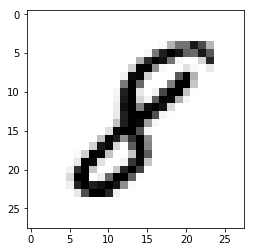

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import tensorflow as tf



(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

import matplotlib.pyplot as plt
%matplotlib inline 
image_index = 7777 # You may select anything up to 60,000

print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])



# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)



In [30]:
model.evaluate(x_test, y_test)
#extract = Model(model.inputs, model.layers[-3]) # Dense(128,...)

10000/10000 [==============================] - 1s 86us/step


[0.06560795710320767, 0.9855999946594238]

In [16]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 

# model: InceptionV3
# extracting feature from images
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")

# used as a multi class classifier
lr = LogisticRegression(maxIter=5, regParam=0.03, 
                        elasticNetParam=0.5, labelCol="label") 

# define a pipeline model
sparkdn = Pipeline(stages=[featurizer, lr])
spark_model = sparkdn.fit(train)

INFO:tensorflow:Froze 376 variables.


2019-12-14 19:26:38,137 INFO (MainThread-8673) Froze 376 variables.


INFO:tensorflow:Converted 376 variables to const ops.


2019-12-14 19:26:38,282 INFO (MainThread-8673) Converted 376 variables to const ops.


Py4JJavaError: An error occurred while calling o194.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3.0 failed 4 times, most recent failure: Lost task 0.3 in stage 3.0 (TID 3765, 172.18.0.4, executor 2): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 168, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 580, in loads
    return pickle.loads(obj, encoding=encoding)
ImportError: No module named 'sparkdl'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage11.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 168, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/spark/python/lib/pyspark.zip/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 580, in loads
    return pickle.loads(obj, encoding=encoding)
ImportError: No module named 'sparkdl'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage11.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


# Evaluation

Now, it's time to evaluate the model performance. We now like to evaluate four evaluation matrics such as F1-score, Precision, Recall, Accuracy.

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# evaluate the model with test set
evaluator = MulticlassClassificationEvaluator() 
transform_test = spark_model.transform(test)

## Evaluation Metrics

In [9]:
print('F1-Score ', evaluator.evaluate(transform_test, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(transform_test,
                                       {evaluator.metricName: 'weightedPrecision'}))
print('Recall ', evaluator.evaluate(transform_test, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(transform_test, 
                                      {evaluator.metricName: 'accuracy'}))


F1-Score  0.8111782234361806
Precision  0.8422058244785519
Recall  0.8090909090909091
Accuracy  0.8090909090909091


## Confusion Metrix

 Here, we'll summarize the performance of a classification model using the confusion matrix.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
'''
- Convert Spark-DataFrame to Pnadas-DataFrame
- Call Confusion Matrix With 'True' and 'Predicted' Label
'''


from sklearn.metrics import confusion_matrix
y_true = transform_test.select("label")
y_true = y_true.toPandas() # convert to pandas dataframe from spark dataframe

y_pred = transform_test.select("prediction")
y_pred = y_pred.toPandas() # convert to pandas dataframe from spark dataframe

cnf_matrix = confusion_matrix(y_true, y_pred,labels=range(10))

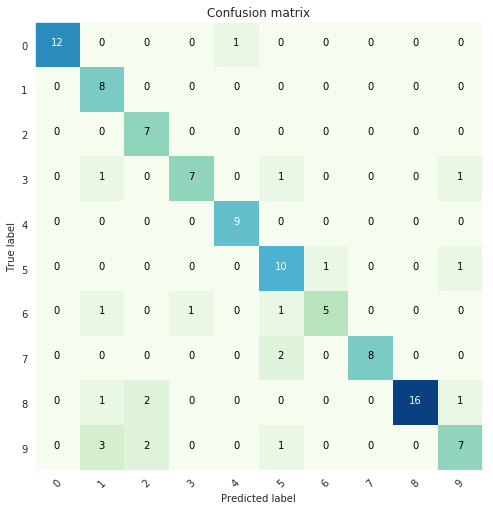

In [14]:
'''
- Visualize the 'Confusion Matrix' 
'''
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")
plt.figure(figsize=(7,7))
plt.grid(False)

# call pre defined function
plot_confusion_matrix(cnf_matrix, classes=range(10)) 

## Classification Report

Here we can also get report on classification of each class by the evaluation matrix.

In [15]:
'''
- Classification Report of each class group
'''

from sklearn.metrics import classification_report

target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       1.00      0.92      0.96        13
     Class 1       0.57      1.00      0.73         8
     Class 2       0.64      1.00      0.78         7
     Class 3       0.88      0.70      0.78        10
     Class 4       0.90      1.00      0.95         9
     Class 5       0.67      0.83      0.74        12
     Class 6       0.83      0.62      0.71         8
     Class 7       1.00      0.80      0.89        10
     Class 8       1.00      0.80      0.89        20
     Class 9       0.70      0.54      0.61        13

   micro avg       0.81      0.81      0.81       110
   macro avg       0.82      0.82      0.80       110
weighted avg       0.84      0.81      0.81       110



In [16]:
train.count(), test.count()

(390, 110)

## ROC AUC Score

Let's also find ROC AUC socre point of the model

In [18]:
'''
- A custom ROC AUC score function for multi-class classification problem
'''

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true,y_pred))

ROC AUC score: 0.9005280079560635


## Predicted Samples

Using though a imagenet weight such model really perform pretty promising to recognise handwritten digits. Moreover we didn't also perform any image processing task to better generalization. Also model being trained on very few amounts of data compared to ImageNet dataset where such model is quite fit.

In [19]:
'''
- Comparing true vs predicted samples
'''

# all columns after transformations
print(transform_test.columns)

# see some predicted output
transform_test.select('image', "prediction", "label").show()

['image', 'label', 'features', 'rawPrediction', 'probability', 'prediction']
+--------------------+----------+-----+
|               image|prediction|label|
+--------------------+----------+-----+
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       8.0|    8|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       1.0|    8|
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       1.0|    9|
|[file:/home/innat...|       0.0|    0|
|[file:/home/innat...|       2.0|    9|
|[file:/home/innat...|       8.0|    8|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       0.0|    0|
|[file:/home/innat...|       4.0|    0|
|[file:/home/innat...|       5.0|    9|
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       3.0|    6|
+--